Testing `mushi` with `stdpopsim` simulations
==

In [1]:
%matplotlib inline

from mushi.ksfs import kSFS
import mushi.histories as hst
import mushi.composition as cmp

import msprime
import stdpopsim
from IPython.display import display, SVG
import numpy as np
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib import pyplot as plt
from scipy.special import expit
import time

## Time grid

In [2]:
change_points = np.logspace(0, np.log10(100000), 100)
t = np.concatenate((np.array([0]), change_points))

## Sawtooth demographic history $\eta(t)$

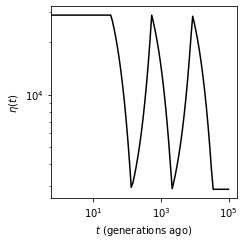

In [3]:
species = stdpopsim.get_species("HomSap")
model = species.get_demographic_model("Zigzag_1S14")
ddb = model.get_demography_debugger()
eta_true = hst.eta(change_points, 2 * ddb.population_size_trajectory(steps=t)[:, 0])

plt.figure(figsize=(3.5, 3.5))
eta_true.plot(c='k')
plt.show()

## Mutation rate history $\mu(t)$
A 96 dimensional history with a mixture of two latent signature: constant and pulse.

/Users/williamdewitt/Applications/miniconda2/envs/mushi/lib/python3.7/site-packages/jax/lib/xla_bridge.py:120: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


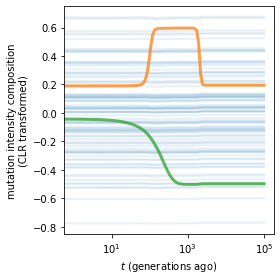

In [4]:
flat = np.ones_like(t)
pulse = expit(.1 * (t - 100)) - expit(.01 * (t - 2000))
ramp = expit(-.01 * (t - 100)) 
n_mutation_types = 96
Z = np.zeros((len(t), n_mutation_types))
mu0 = 1
np.random.seed(0)

Z[:, 0] = mu0 * (1 * flat + .5 * pulse)

Z[:, 1] = mu0 * (.5 * flat + .4 * ramp)

for col in range(2, n_mutation_types):
    scale = np.random.lognormal(-.2, .3)
    pulse_weight = 5 if col == 0 else 0
    Z[:, col] = mu0 * scale * flat

mu_true = hst.mu(change_points, Z)

plt.figure(figsize=(4, 4))
mu_true.plot(range(2, n_mutation_types), alpha=0.1, lw=2, c='C0', clr=True)
mu_true.plot((0,), alpha=0.75, lw=3, c='C1', clr=True)
mu_true.plot((1,), alpha=0.75, lw=3, c='C2', clr=True)
plt.show()

In [5]:
# estimate constant total mutation rate using most recent time point
mu0 = mu_true.Z[0, :].sum()
print(mu0)

83.11894862750988


## `stdpopsim` simulation
- 200 sampled haplotypes
- generate initial tree sequence without mutations, then we'll place mutations according to the MuSH

In [6]:
n = 200
chrom = 1
species = stdpopsim.get_species('HomSap')
contig = species.get_contig(f'chr{chrom}')
contig = stdpopsim.Contig(recombination_map=contig.recombination_map, mutation_rate=0, genetic_map=contig.genetic_map)
model = stdpopsim.PiecewiseConstantSize(eta_true.y[0] / 2, *zip(change_points, eta_true.y[1:] / 2))
samples = model.get_samples(n)
engine = stdpopsim.get_default_engine()
ts = engine.simulate(model, contig, samples, mutation_rate=0)

In [7]:
ts.num_trees

250501

### First tree in the sequence

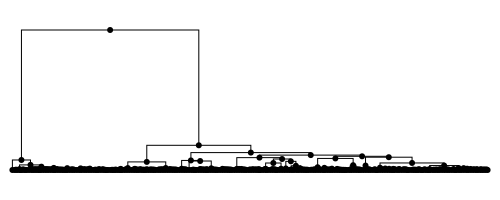

In [8]:
display(SVG(ts.first().draw(format='svg', width=500, height=200, node_labels={},
                                       mutation_labels={})))

## Simulate $k$-SFS
- place mutations on simulated tree sequence according to $\boldsymbol\mu(t)$
- iterate over mutation types and epochs
- compute component of $k$-SFS for each iterate

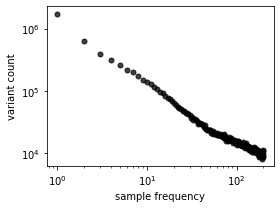

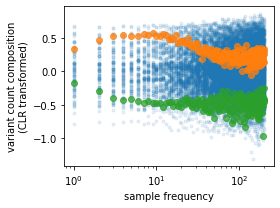

In [9]:
X = np.zeros((n - 1, n_mutation_types))

for j in range(n_mutation_types):
    ts_j = ts
    for start_time, end_time, mutation_rate in mu_true.epochs():
        print(f'mutation type {j + 1}, epoch boundaries: ({start_time:.2f}, {end_time:.2f}), μ: {mutation_rate[j]:.2f}     ', flush=True, end='     \r')
        # note: the factor of 1 / chrom.length is needed to scale the mutation rate from sites to genomes
        ts_j = msprime.mutate(ts_j,
                              rate=mutation_rate[j] / species.genome.chromosomes[chrom - 1].length,                                   
                              start_time=start_time,
                              end_time=end_time,
                              random_seed=1,
                              keep=True)
    X[:, j] = ts_j.allele_frequency_spectrum(polarised=True, span_normalise=False)[1:-1]
    
ksfs = kSFS(X=X)

plt.figure(figsize=(4, 3))
ksfs.plot_total(kwargs=dict(ls='', marker='o', ms=5, c='k', alpha=0.75),
                line_kwargs=dict(c='C0', alpha=0.75, lw=3),
                fill_kwargs=dict(color='C0', alpha=0.1))
plt.yscale('log')

plt.figure(figsize=(4, 3))
ksfs.plot(range(2, n_mutation_types), clr=True, kwargs=dict(alpha=0.1, ls='', marker='.', c='C0'))
ksfs.plot((0,), clr=True, kwargs=dict(alpha=0.75, ls='', marker='o', c='C1'))
ksfs.plot((1,), clr=True, kwargs=dict(alpha=0.75, ls='', marker='o', c='C2'))
plt.show()

In [10]:
ksfs.X.sum()

8274839.0

### TMRCA CDF

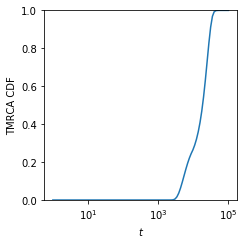

In [11]:
plt.figure(figsize=(3.5, 3.5))
plt.plot(change_points, ksfs.tmrca_cdf(eta_true))
# TODO: qq plot with empirical CDF from ts!
# plt.axvline(max(root.time for root in ts.roots()))
plt.xlabel('$t$')
plt.ylabel('TMRCA CDF')
plt.ylim([0, 1])
plt.xscale('log')
plt.tight_layout()
plt.show()

## Infer $\eta(t)$ and $\boldsymbol\mu(t)$

inferring η(t)
initial objective -8.950976e+07
iteration 10000, objective -8.960e+07, relative change 1.100e-12                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

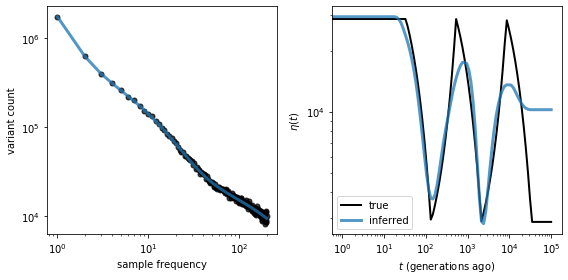

In [42]:
ksfs.clear_eta()
ksfs.clear_mu()

# define regularization parameters and convergence criteria
convergence = dict(tol=0, max_iter=10000)
regularization_eta = dict(alpha_tv=2e0, alpha_spline=1e2, alpha_ridge=1e-10)

ksfs.infer_history(change_points, mu0, infer_mu=False,
                   **regularization_eta, **convergence)

plt.figure(figsize=(8, 4))
plt.subplot(121)
ksfs.plot_total(kwargs=dict(ls='', marker='o', ms=5, c='k', alpha=0.75),
                line_kwargs=dict(c='C0', alpha=0.75, lw=3),
                fill_kwargs=dict(color='C0', alpha=0.1))
plt.yscale('log')

plt.subplot(122)
eta_true.plot(c='k', lw=2, label='true')
ksfs.eta.plot(lw=3, alpha=0.75, label='inferred')
plt.legend()
plt.show()

inferring μ(t) conditioned on η(t)
initial objective -5.223132e+07
iteration 10000, objective -5.223e+07, relative change 1.455e-13                                                                                                                                                                                                                                                     
maximum iteration 10000 reached with relative change in objective function 1.5e-13


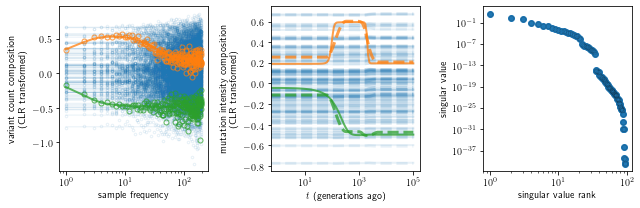

In [66]:
ksfs.clear_mu()

# define regularization parameters and convergence criteria
regularization_mu = dict(beta_rank=2e1, beta_tv=1e2, beta_spline=1e3, beta_ridge=1e-10)
convergence = dict(tol=0, max_iter=10000)

ksfs.infer_history(change_points, mu0, infer_eta=False,
                   **regularization_mu, **convergence)

plt.figure(figsize=(9, 3))

plt.subplot(131)
ksfs.plot(range(2, n_mutation_types), clr=True, kwargs=dict(alpha=0.1, ls='', marker='.', ms=5, mfc='none', c='C0', rasterized=True),
          line_kwargs=dict(alpha=0.1, lw=1, c='C0', rasterized=True))
ksfs.plot((0,), clr=True, kwargs=dict(alpha=0.75, ls='', marker='.', ms=10, mfc='none', c='C1'),
          line_kwargs=dict(alpha=0.75, lw=2, c='C1'))
ksfs.plot((1,), clr=True, kwargs=dict(alpha=0.75, ls='', marker='.', ms=10, mfc='none', c='C2'),
          line_kwargs=dict(alpha=0.75, lw=2, c='C2'))

plt.subplot(132)
mu_true.plot(range(2, n_mutation_types), alpha=0.1, lw=2, c='C0', clr=True, rasterized=True)
ksfs.mu.plot(range(2, n_mutation_types), alpha=0.1, lw=3, ls='--', c='C0', clr=True, rasterized=True)
mu_true.plot((0,), alpha=0.75, lw=2, c='C1', clr=True)
ksfs.mu.plot((0,), alpha=0.75, lw=3, ls='--', c='C1', clr=True)
mu_true.plot((1,), alpha=0.75, lw=2, c='C2', clr=True)
ksfs.mu.plot((1,), alpha=0.75, lw=3, ls='--', c='C2', clr=True)

plt.subplot(133)
σ = np.linalg.svd(cmp.ilr(ksfs.mu.Z), compute_uv=False)
x = np.arange(1, len(σ) + 1)
plt.scatter(x, σ)
plt.plot(x, σ, 'ko', ms=5, mfc='none', mew=.1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('singular value rank')
plt.ylabel('singular value')
plt.tight_layout()
plt.show()

## Final plots

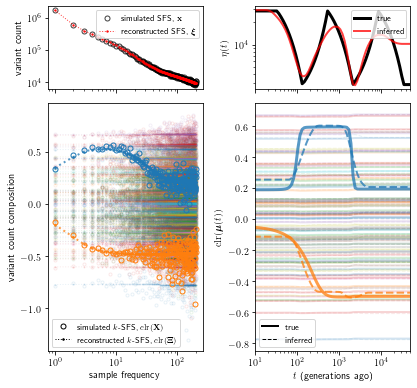

In [67]:
# set this to e.g. your Downloads folder path if you want plots saved to pdfs
plot_dir = None

mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

fig, axes = plt.subplots(nrows=2, ncols=2, sharex='col', figsize=(5.9, 5.5), gridspec_kw={'height_ratios': [1, 3]})

plt.sca(axes[0, 0])
ksfs.plot_total(kwargs=dict(ls='', alpha=0.75, marker='o', ms=5, mfc='none', c='k', label=r'simulated SFS, $\mathbf x$'),
                line_kwargs=dict(c='r', ls=':', marker='.', ms=3, alpha=0.75, lw=1, label=r'reconstructed SFS, $\boldsymbol{\xi}$'),
                fill_kwargs=dict(alpha=0))
plt.yscale('log')
plt.xlabel(None)
plt.legend(fontsize=8)

plt.sca(axes[1, 0])
ksfs.plot(range(2, n_mutation_types), clr=True, kwargs=dict(alpha=0.1, ls='', marker='o', ms=3, mfc='none', rasterized=True),
          line_kwargs=dict(ls=':', marker='.', ms=2, alpha=0.1, lw=1, rasterized=True))
ksfs.plot((0,), clr=True, kwargs=dict(ls='', marker='o', ms=5, mfc='none', c='C0'),
          line_kwargs=dict(ls=':', marker='.', ms=3, alpha=0.75, lw=2, c='C0'))
ksfs.plot((1,), clr=True, kwargs=dict(ls='', marker='o', ms=5, mfc='none', c='C1'),
          line_kwargs=dict(ls=':', marker='.', ms=3, alpha=0.75, lw=2, c='C1'))
plt.ylabel('variant count composition')
legend_elements = [Line2D([0], [0], ls='', marker='o', ms=5, mfc='none', color='k', label=r'simulated $k$-SFS, $\mathrm{clr}(\mathbf X)$'),
                   Line2D([0], [0], ls=':', marker='.', color='k', ms=3, lw=1, label=r'reconstructed $k$-SFS, $\mathrm{clr}(\boldsymbol\Xi)$')]
plt.legend(handles=legend_elements, loc='lower left', fontsize=8)

plt.sca(axes[0, 1])
eta_true.plot(c='k', alpha=1, lw=3, label='true')
ksfs.eta.plot(c='r', alpha=0.75, lw=2, label='inferred')
plt.legend(fontsize=8, loc='upper right')
plt.xlabel(None)

plt.sca(axes[1, 1])
mu_true.plot(range(2, n_mutation_types), alpha=0.2, lw=2, rasterized=True, clr=True)
plt.gca().set_prop_cycle(None)
ksfs.mu.plot(range(2, n_mutation_types), alpha=0.1, lw=1, ls='--', rasterized=True, clr=True)
mu_true.plot((0,), alpha=0.75, lw=3, c='C0', clr=True)
ksfs.mu.plot((0,), alpha=0.75, lw=2, c='C0', clr=True, ls='--')
mu_true.plot((1,), alpha=0.75, lw=3, c='C1', clr=True)
ksfs.mu.plot((1,), alpha=0.75, lw=2, c='C1', clr=True, ls='--')
plt.ylabel(r'$\mathrm{clr}(\boldsymbol{\mu}(t))$')
legend_elements = [Line2D([0], [0], color='k', lw=2, label='true'),
                   Line2D([0], [0], color='k', ls='--', lw=1, label='inferred')]
plt.legend(handles=legend_elements, loc='lower left', fontsize=8)
plt.xlim([1e1, 5e4])

plt.tight_layout()
if plot_dir:
    plt.savefig(f'{plot_dir}/sim.pdf', dpi=300)
plt.show()